In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm
from tqdm import tqdm as _tqdm

import seaborn as sns
sns.set(color_codes=True)

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

## Part 1: Option valuation

In [2]:
def compute_value_bin_tree(S0, K, T, n, sigma, r, call=True, european=True):
    """
    Get value of an option using binomial tree method.
    
    Params:
        S0: spot price
        K: strike price
        T: expiration time in years
        n: steps in tree
        sigma: volatility
        r: risk-free rate
        call: True/False. False means it's a put option
        european: True/False. False means it's American option
        
    Returns:
        Value of option at time t=0
        Delta hedging parameter
    """
    
    sigma = sigma / 100 if sigma > 1 else sigma
    r = r / 100 if r > 1 else r
    multip = 1 if call else -1
    
    # Get tree parameters
    dt = T / n
    u = math.exp(sigma * math.sqrt(dt))
    d = 1 / u
    rf_discount = math.exp(r * dt)
    p = (rf_discount - d) / (u - d)
    
    # Setup variables
    stock_value = np.zeros((n+1, n+1))
    option_value = np.zeros((n+1, n+1))
    stock_value[0, 0] = S0

    # Fill in stock values at each time step
    for i in range(1, n+1):
        stock_value[0, i] = stock_value[0, i-1] * u
        for j in range(1, i+1):
            stock_value[j, i] = stock_value[j-1, i-1] * d

    # Compute option value at time T
    for i in range(n+1):
        option_value[i, n] = max(0, multip * (stock_value[i, n] - K))
        
    # For timesteps T-1 -> 0 compute option value using formula
    for i in range(n-1, -1, -1):
        for j in range(i+1):
            option_value[j, i] = (p * option_value[j, i+1] + (1-p) * option_value[j+1, i+1]) / rf_discount
            if not european:  # Added for American option, extra check for early exercise
                option_value[j, i] = max(option_value[j, i], multip * (stock_value[j, i] - K))
    
    delta = (option_value[0, 1] - option_value[1, 1]) / (stock_value[0, 1] - stock_value[1, 1])
    
    return option_value[0, 0], delta

In [3]:
def option_value_bs(St, K, T, sigma, r, t=0):
    """
    Analytic evaluation of European call option.
    
    Params:
        St: stock price at time t
        K: strike price
        T: maturity
        sigma: volatility
        r: risk-free rate
        t: time step prior to maturity time
        
    Returns:
        Value of option at time t
    """
    d1 = (math.log(St/K) + (r + sigma ** 2 * 0.5) * (T - t)) / (sigma * math.sqrt(T - t))
    d2 = d1 - sigma * math.sqrt(T - t)
    
    return St * norm.cdf(d1) - K * math.exp(-r * (T - t)) * norm.cdf(d2)

In [4]:
def hedge_parameter_bs(St, K, T, sigma, r, t=0):
    """
    Analytic evaluation of hedge parameter at time t
    
    Params:
        St: stock price at time t
        K: strike price
        T: maturity
        sigma: volatility
        r: risk-free rate
        t: time step prior to maturity time
        
    Returns:
        Hedge parameter at time t
    """
    
    return norm.cdf((math.log(St/K) + (r + sigma ** 2 * 0.5) * (T - t)) / (sigma * math.sqrt(T - t)))

### 1 Approximate the price of the option 

In [5]:
# price by binomial tree for call option
opt, delta = compute_value_bin_tree(S0=100, K=99, T=1, n=50, sigma=0.20, r=0.06, call=True, european=True)
print("Price approximated by binomial tree for European call: %.4f,  delta: %.4f" % (opt, delta))

# comparing price to analytical value
price = option_value_bs(St=100, K=99, T=1, sigma=0.20, r=0.06, t=0)
print("\nAnalytic value European call: %.4f" % price)

Price approximated by binomial tree for European call: 11.5464,  delta: 0.6726

Analytic value European call: 11.5443


Price of the approximated value is very close to the price of the analytical value

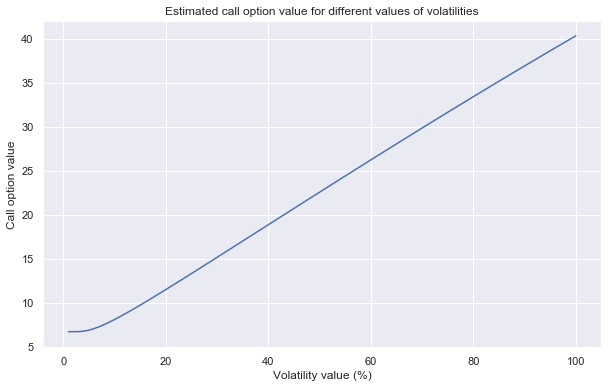

In [6]:
# Plot of option value vs. volatilities
volatilities = np.linspace(0.01, 1, 100)

estimated_values = []

for sigma in volatilities:
    value, _ = compute_value_bin_tree(S0=100, K=99, T=1, n=50, sigma=sigma,
                                      r=0.06, call=True, european=True)
    estimated_values.append(value)

plt.figure(figsize=(10, 6))
plt.plot(volatilities, estimated_values, linewidth=1.5)
plt.title("Estimated call option value for different values of volatilities")
plt.xlabel("Volatility value (%)")
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1], ['0', '20', '40', '60', '80', '100'])
plt.yticks(np.arange(5, 41, 5))
plt.ylabel("Call option value")
plt.show()

### 2. Convergence and complexity of method


100%|██████████| 595/595 [01:06<00:00,  8.92it/s] 


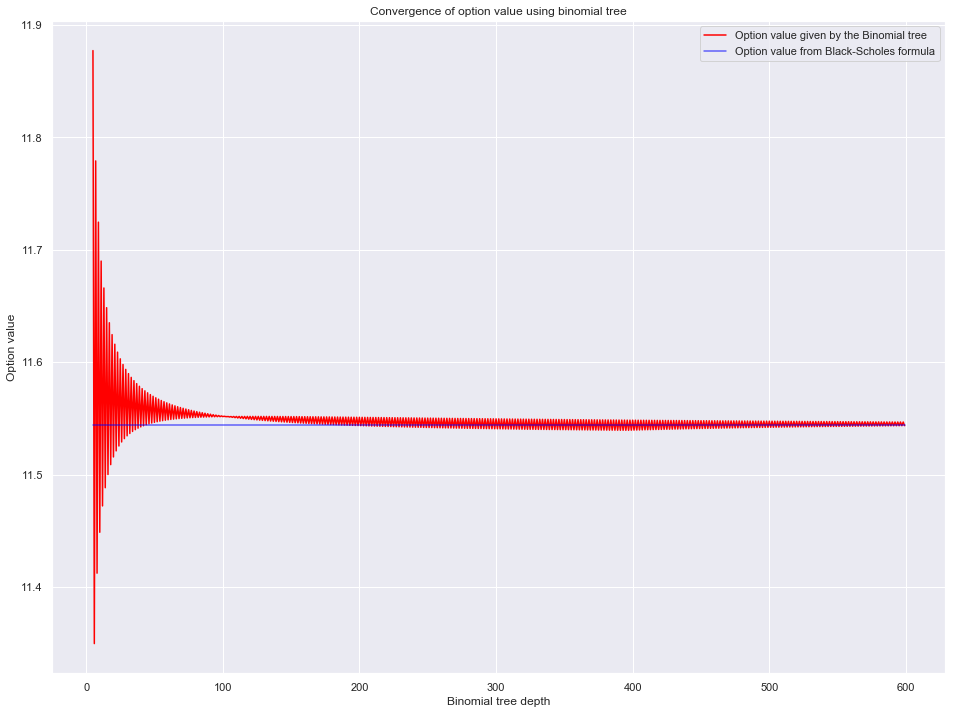

In [7]:
steps = np.arange(5, 600)
opt_values = []

for s in tqdm(steps):
    value, delta = compute_value_bin_tree(S0=100, K=99, T=1, n=s, sigma=0.20, r=0.06)
    opt_values.append(value)
    
value_bs = option_value_bs(100, 99, 1, 0.2, 0.06)

plt.figure(figsize=(16, 12))
plt.plot(steps, opt_values, color='red', linewidth=1.5, label='Option value given by the Binomial tree')
plt.plot(steps, [value_bs for i in steps], color='blue', linewidth=1.5, alpha=0.6, label='Option value from Black-Scholes formula')
plt.title("Convergence of option value using binomial tree")
plt.xlabel("Binomial tree depth")
plt.ylabel("Option value")
plt.legend()
plt.show()

### 3. Hedge parameter


In [8]:
# Compute the hedge parameter from the binomial tree
_, delta = compute_value_bin_tree(S0=100, K=99, T=1, n=50, sigma=0.20, r=0.06, call=True, european=True)
print("Hedgep parameter from binomial tree: %.4f" % (delta))

# Compare with analytical values
print("Analytic hedge parameter: %.4f" % (hedge_parameter_bs(100, 99, 1, 0.20, 0.06, 0)))

Hedgep parameter from binomial tree: 0.6726
Analytic hedge parameter: 0.6737


Estimated hedge parameter is very close to the analytical value

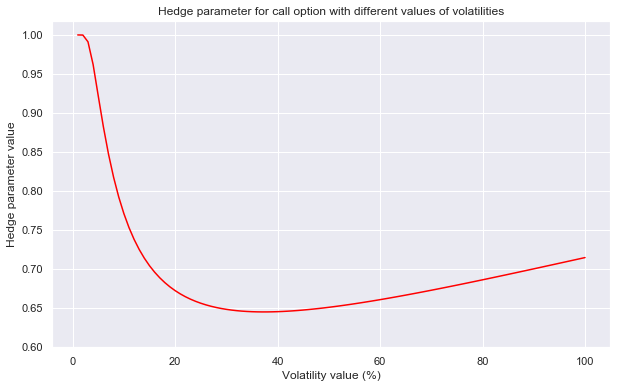

In [9]:
# Plot of hedge parameters vs. volatilities
volatilities = np.linspace(0.01, 1, 100)

estimated_deltas = []

for sigma in volatilities:
    _, delta = compute_value_bin_tree(S0=100, K=99, T=1, n=50, sigma=sigma,
                                      r=0.06, call=True, european=True)
    estimated_deltas.append(delta)

plt.figure(figsize=(10, 6))
plt.plot(volatilities, estimated_deltas, color='red', linewidth=1.5)
plt.title("Hedge parameter for call option with different values of volatilities")
plt.xlabel("Volatility value (%)")
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1], ['0', '20', '40', '60', '80', '100'])
plt.yticks(np.arange(0.60, 1.01, 0.05))
plt.ylabel("Hedge parameter value")
plt.show()

### 4. American call and put

In [10]:
# Initial values
opt, delta = compute_value_bin_tree(S0=100, K=99, T=1, n=50, sigma=0.20, r=0.06, call=True, european=False)
print("American call value with initial parameters 0.2: %.4f,  delta:%.4f" % (opt, delta))

opt, delta = compute_value_bin_tree(S0=100, K=99, T=1, n=50, sigma=0.20, r=0.06, call=False, european=False)
print("\nAmerican put value with initial parameters 0.2: %.4f,  delta:%.4f" % (opt, delta))

opt, delta = compute_value_bin_tree(S0=100, K=99, T=1, n=50, sigma=0.20, r=0.06, call=False, european=True)
print("\nEuropean put value with initial parameters 0.2: %.4f,  delta:%.4f" % (opt, delta))

American call value with initial parameters 0.2: 11.5464,  delta:0.6726

American put value with initial parameters 0.2: 5.3478,  delta:-0.3820

European put value with initial parameters 0.2: 4.7811,  delta:-0.3274


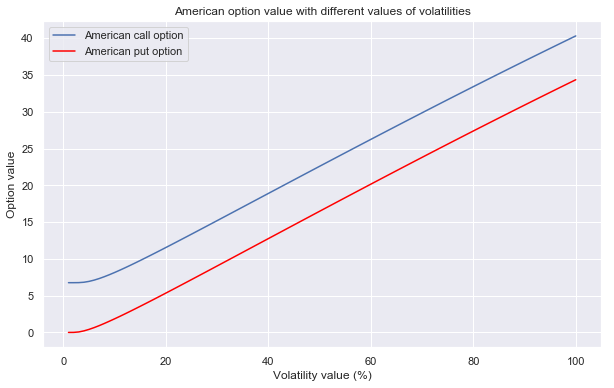

In [11]:
# Plot of American call and put
volatilities = np.linspace(0.01, 1, 100)

american_call = []
american_put = []

for sigma in volatilities:
    call_value, _ = compute_value_bin_tree(S0=100, K=99, T=1, n=50, sigma=sigma,
                                           r=0.06, call=True, european=False)
    american_call.append(call_value)
    
    put_value, _ = compute_value_bin_tree(S0=100, K=99, T=1, n=50, sigma=sigma,
                                          r=0.06, call=False, european=False)
    american_put.append(put_value)

plt.figure(figsize=(10, 6))
plt.plot(volatilities, american_call, linewidth=1.5, label='American call option')
plt.plot(volatilities, american_put, linewidth=1.5, label='American put option', color='red')
plt.title("American option value with different values of volatilities")
plt.xlabel("Volatility value (%)")
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1], ['0', '20', '40', '60', '80', '100'])
plt.ylabel("Option value")
plt.legend()
plt.show()

### Comparison of American and European call and put

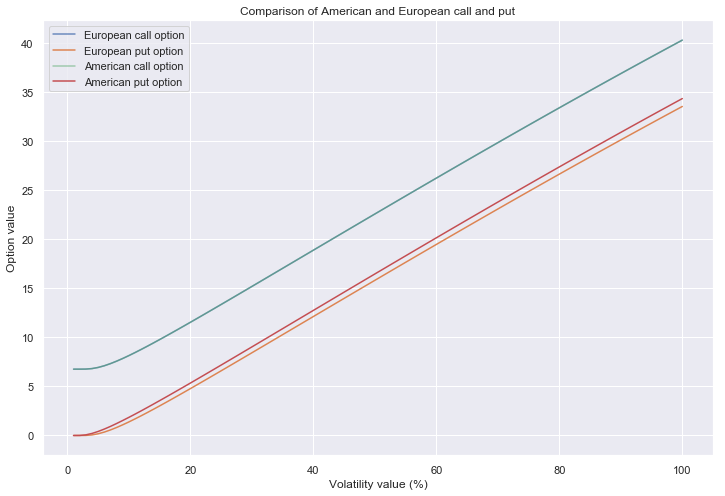

In [12]:
# Plot of American and European call and put
volatilities = np.linspace(0.01, 1, 100)

american_call = []
american_put = []
european_call = []
european_put = []

for sigma in volatilities:
    euro_call, _ = compute_value_bin_tree(S0=100, K=99, T=1, n=50, sigma=sigma,
                                          r=0.06, call=True, european=True)
    european_call.append(euro_call)
    
    euro_put, _ = compute_value_bin_tree(S0=100, K=99, T=1, n=50, sigma=sigma,
                                         r=0.06, call=False, european=True)
    european_put.append(euro_put)
    
    amer_call, _ = compute_value_bin_tree(S0=100, K=99, T=1, n=50, sigma=sigma,
                                          r=0.06, call=True, european=False)
    american_call.append(amer_call)
    
    amer_put, _ = compute_value_bin_tree(S0=100, K=99, T=1, n=50, sigma=sigma,
                                         r=0.06, call=False, european=False)
    american_put.append(amer_put)

plt.figure(figsize=(12, 8))
plt.plot(volatilities, european_call, linewidth=1.5, label='European call option', alpha=0.8)
plt.plot(volatilities, european_put, linewidth=1.5, label='European put option', alpha=1)
plt.plot(volatilities, american_call, linewidth=1.5, label='American call option', alpha=0.5)
plt.plot(volatilities, american_put, linewidth=1.5, label='American put option', alpha=1)
plt.title("Comparison of American and European call and put")
plt.xlabel("Volatility value (%)")
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1], ['0', '20', '40', '60', '80', '100'])
plt.ylabel("Option value")
plt.legend()
plt.show()

## Part 2: Hedging Simulations

In [13]:
def run_simulation(S0, K, T, period, sigma_opt, sigma_stock, r):
    """
    Run delta hedge simulation.
    
    Params:
        S0: start price of stock
        K: strike price of call option
        T: expiration time in years
        period: time period for hedge adjustment (week or day)
        sigma_opt: volatility for option valuation
        sigma_stock: volatility for stock price process
        r: interest rate
        
    Returns:
        DataFrame with the details of simulation
    """
    if period == "day":
        n = 365
    else:
        n = 52
    
    dt = T / n

    price = np.zeros(n)
    change = np.zeros(n)
    delta = np.zeros(n)
    stock_val = np.zeros(n)
    borrowings = np.zeros(n)
    port_val = np.zeros(n)
    opt_val = np.zeros(n)
    error = np.zeros(n)

    price[0] = S0

    for i in range(n):
        # Compute current price and price change for next period
        price[i] = S0 if i == 0 else price[i-1] + change[i-1]
        change[i] = r * price[i] * dt + sigma_stock * math.sqrt(dt) * price[i] * np.random.randn(1)[0]

        # Get option value and hedge param from BS formula
        opt_val[i] = option_value_bs(price[i], K, T, sigma_opt, r, i*dt)
        delta[i] = hedge_parameter_bs(price[i], K, T, sigma_opt, r, i*dt)

        # Compute stock holding value and amount of borrowings
        if i == 0:
            stock_val[i] = delta[i] * price[i]
            borrowings[i] = stock_val[i] - opt_val[i]
        else:
            change_from_delta = (delta[i] - delta[i-1]) * price[i]
            stock_change = price[i] / price[i-1] * stock_val[i-1]

            stock_val[i] = stock_change + change_from_delta
            borrowings[i] = borrowings[i-1] * math.exp(r * dt) + change_from_delta
            
        # Determine portfolio value (Stock holding - Borrowings) and error (Diff to option value)
        port_val[i] = stock_val[i] - borrowings[i]
        error[i] = port_val[i] - opt_val[i]
        
    sim = pd.DataFrame({'Price':price, 'Change':change, 'Delta':delta, 'StockVal':stock_val,
                        'Borrowings':borrowings, 'PortVal':port_val, 'OptVal':opt_val, 'Error':error})
    return sim

In [14]:
def plot_simulation_data(simulation):
    n = len(simulation)
    
    # Plot Option value vs portfolio
    plt.figure(figsize=(16, 4))
    plt.plot(np.arange(n), simulation['OptVal'], linewidth=1.5, label='Option value', alpha=0.8)
    plt.plot(np.arange(n), simulation['PortVal'], linewidth=1.5, label='Replicating portfolio value', alpha=0.6)
    plt.title("Option vs. replicating portfolio")
    plt.xlabel("Time step")
    plt.ylabel("Value")
    plt.legend()
    plt.show()
    
    # Plot error
    plt.figure(figsize=(16, 4))
    plt.plot(np.arange(n), simulation['Error'], linewidth=1.5, color='black', alpha=0.6)
    plt.title("Delta hedging error")
    plt.xlabel("Time step")
    plt.ylabel("Error value")
    plt.show()

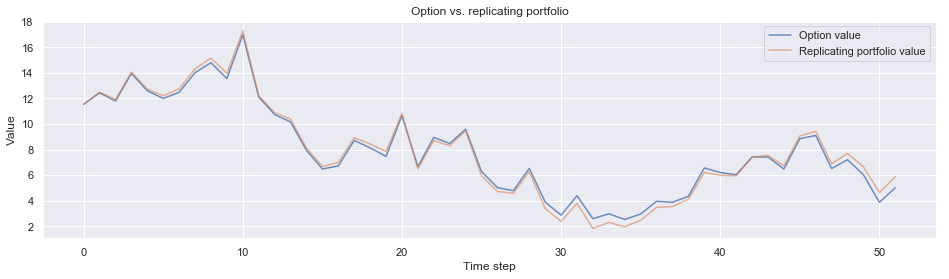

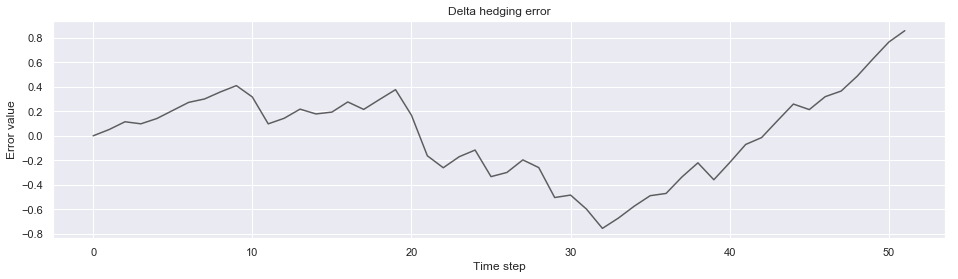

In [15]:
simulation = run_simulation(S0=100, K=99, T=1, period='week', sigma_opt=0.2, sigma_stock=0.2, r=0.06)
plot_simulation_data(simulation)

In [21]:
def plot_error_distribution(err, save=False, fname='abc.png'):
    plt.figure(figsize=(10, 6))
    sns.distplot(err, hist=True, rug=True)
    if save:
        plt.savefig(fname)
    plt.show()

def experiment(sigma_stock=0.2, period='week', n=1000):
    errors = []
    for i in tqdm(range(n)):
        simulation = run_simulation(S0=100, K=99, T=1, period=period, sigma_opt=0.2,
                                    sigma_stock=sigma_stock, r=0.06)
        errors.append(simulation['Error'].iloc[-1])
        
    return errors

### Experiments

Weekly, 20%


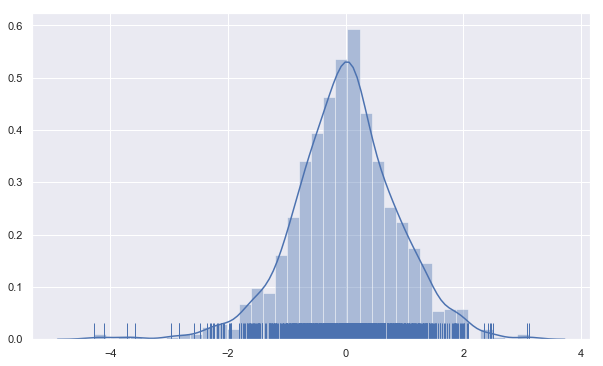


Daily, 20%


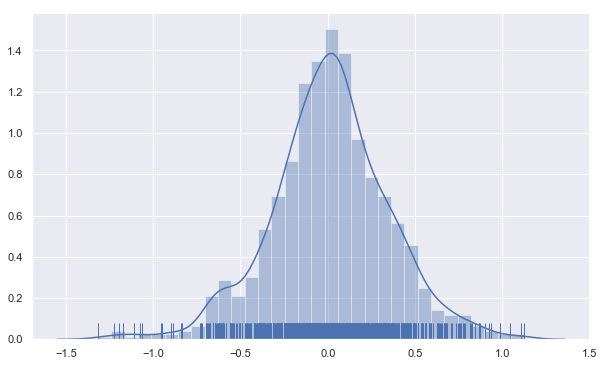

In [24]:
errors_sigma_20_week = experiment()
errors_sigma_20_day = experiment(period='day')

print('Weekly, 20%')
plot_error_distribution(errors_sigma_20_week)

print('\nDaily, 20%')
plot_error_distribution(errors_sigma_20_day)

In [18]:
sim_errors_sigma = {'week':{}, 'day':{}}
volatilities = [0.05, 0.1, 0.4, 0.7]

for p in ['week', 'day']:
    for vol in volatilities:
        sim_errors_sigma[p][vol] = experiment(sigma_stock=vol, period=p)


for vol in volatilities:
    for p in ['week', 'day']:
        print('%s - vol %.2f' % (p, vol))
        plot_error_distribution(sim_errors_sigma[p][vol])